In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

# Data Fields

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** 

    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

### Collinearities to watch out for

**`weather`** will be collinear with **`temp`**, **`atemp`**, **`humidity`**, **`windspeed`** to some degree.  

I will use regularization to handle some of the collinearity, I will also potentially apply some feature selection


##### Load Clean and Dummy-ize our variables

In [141]:
train = pd.read_csv('data/train.csv')
hold_out = pd.read_csv('data/test.csv')

def clean_frame(df):
    seasons = {'spring':1, 'summer':2, 'winter':3, 'fall':4}
    for season in seasons.iterkeys():
        df[season] = df['season'].isin([seasons[season]])

    weather_types = {'clear':1, 'mist':2, 'light':3, 'heavy':4}
    for weather in weather_types:
        df[weather] = df['weather'].isin([weather_types[weather]])

    ### drop stuff we don't need ###
    df = df.drop(['season', 'weather'], axis=1)
    df = df.set_index('datetime')

    ### Rearrange columns
    cols = df.columns
    cols = cols[6:9].append(cols[:6]).append(cols[9:])
    df = df[cols]
    df.index = pd.to_datetime(df.index)
    return df

train = clean_frame(train)

### Collinearity

Weather, humidity, temperature are collinear with the seasons, so any time series analysis would need to account for this effect. 

I suspect that weather's effect on whether people will use a bike are somewhat transient.  70 degrees feels like a great day for a bike ride, but if it's been 40 degrees for weeks, a 55 degree day may also feel similar.  

In [3]:
train.head(2)

,casual,registered,count,holiday,workingday,temp,humidity,windspeed,spring,fall,winter,summer,heavy,light,clear,mist
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,3,13,16,0,0,9.84,81,0.0,True,False,False,False,False,False,True,False
2011-01-01 01:00:00,8,32,40,0,0,9.02,80,0.0,True,False,False,False,False,False,True,False


In [4]:
def pairplot(train, pair_variables, y_var):
    g = sns.pairplot(train[pair_variables],
                 kind='reg',
                 x_vars=pair_variables,
                y_vars=y_var,
                size=5)
    g.set(ylim=(0, 1500))


### Count on Working Days

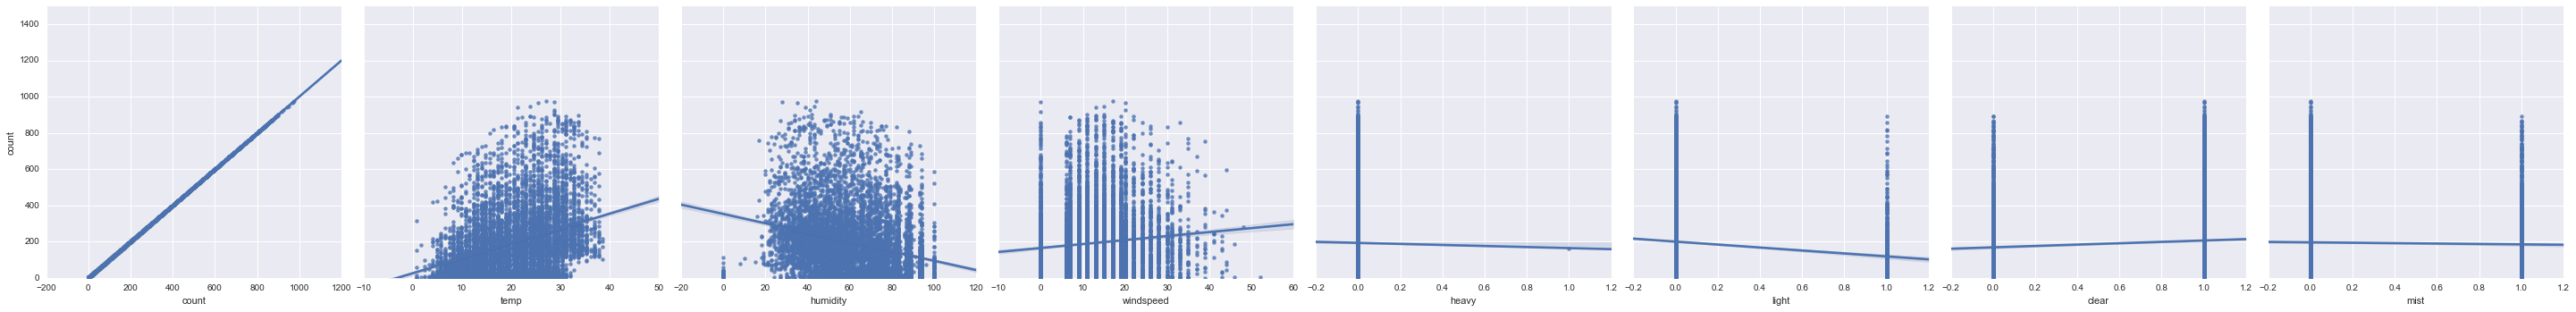

In [5]:
y = 'count'
pairplot(train[train['workingday'] == 1], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

### Count on Weekend

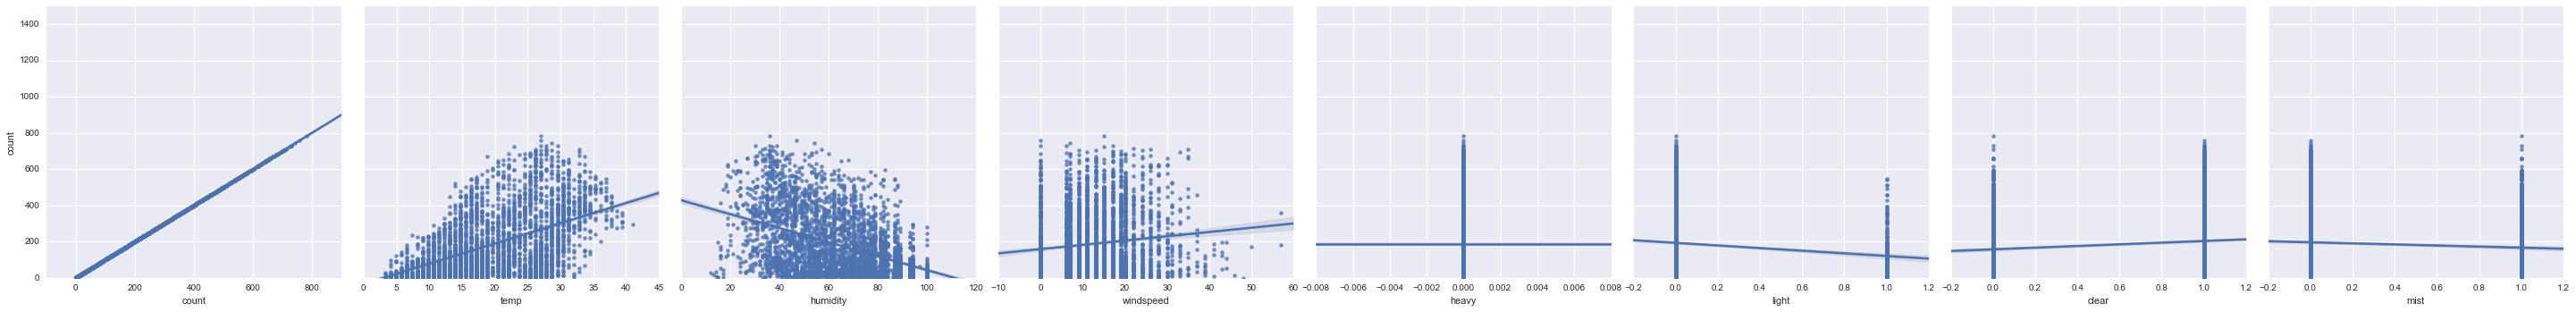

In [6]:
y = 'count'
pairplot(train[train['workingday'] == 0], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

### Registered on Working Days

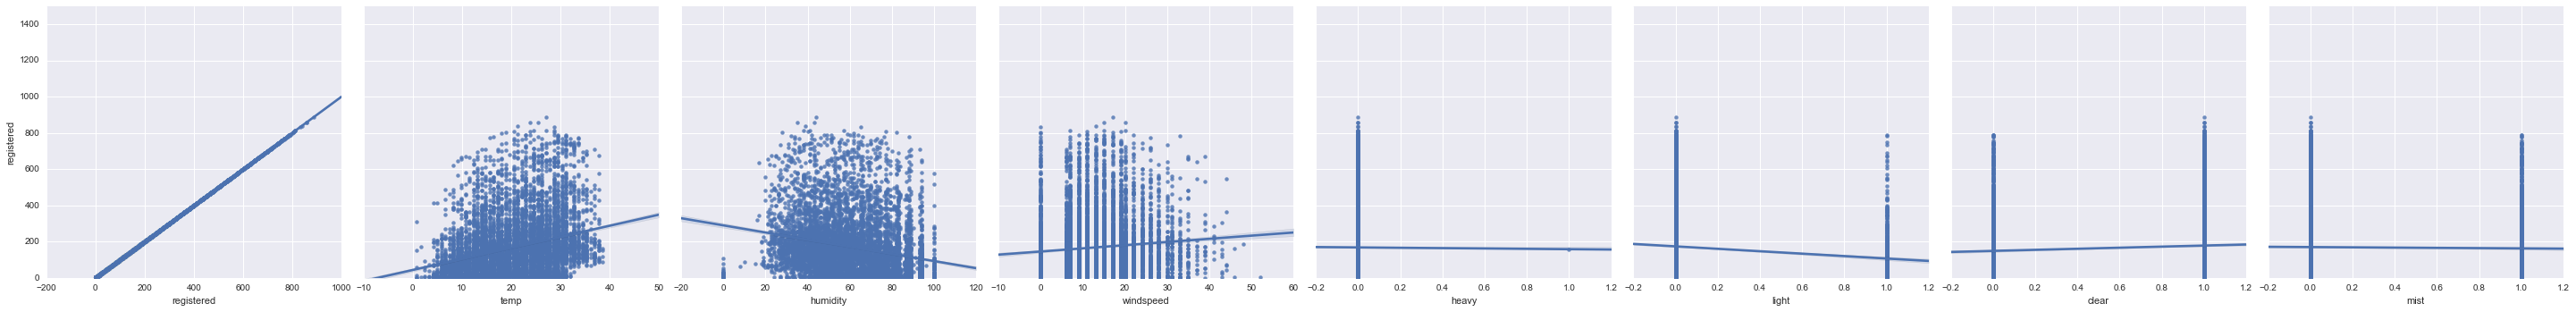

In [7]:
y = 'registered'
pairplot(train[train['workingday'] == 1], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

### Registered on Weekend

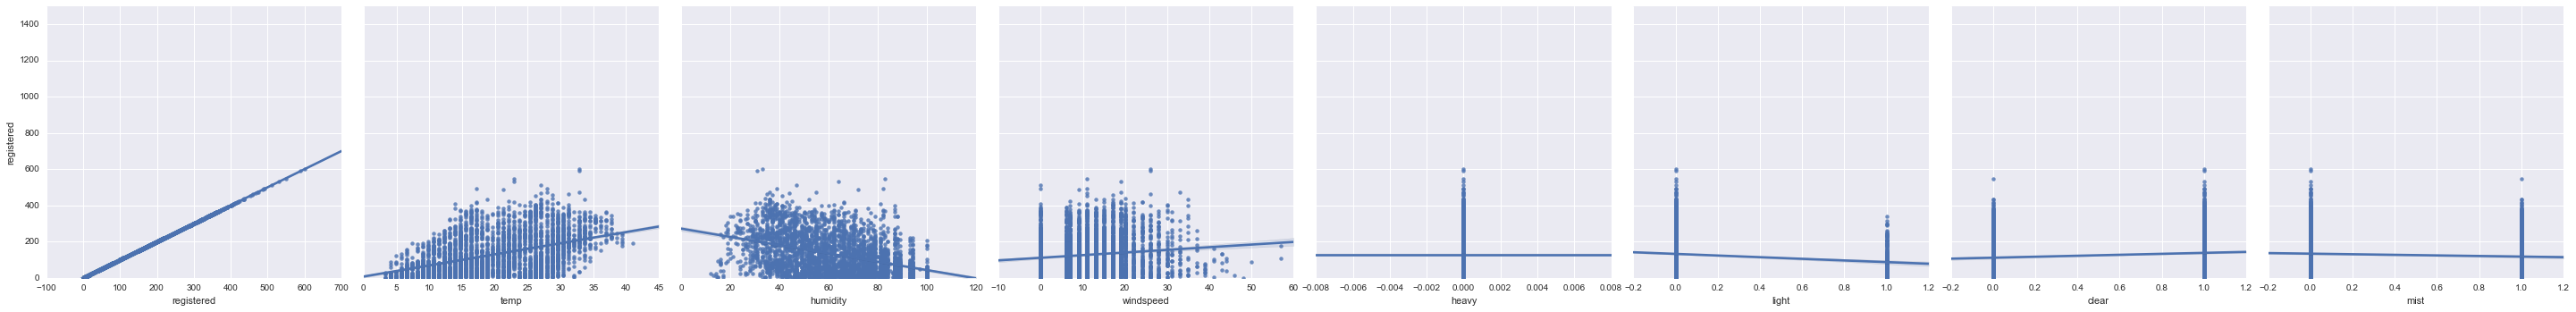

In [8]:
y = 'registered'
pairplot(train[train['workingday'] == 0], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

### Casual on Working Days

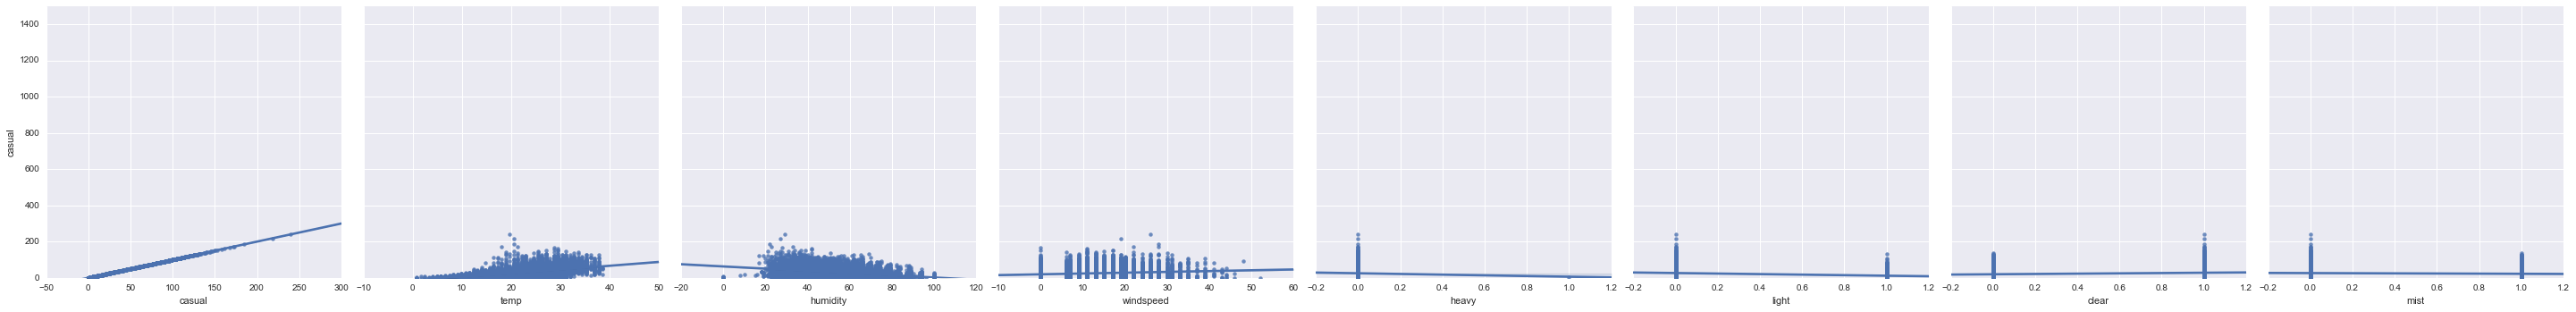

In [9]:
y = 'casual'
pairplot(train[train['workingday'] == 1], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

### Casual on Weekend

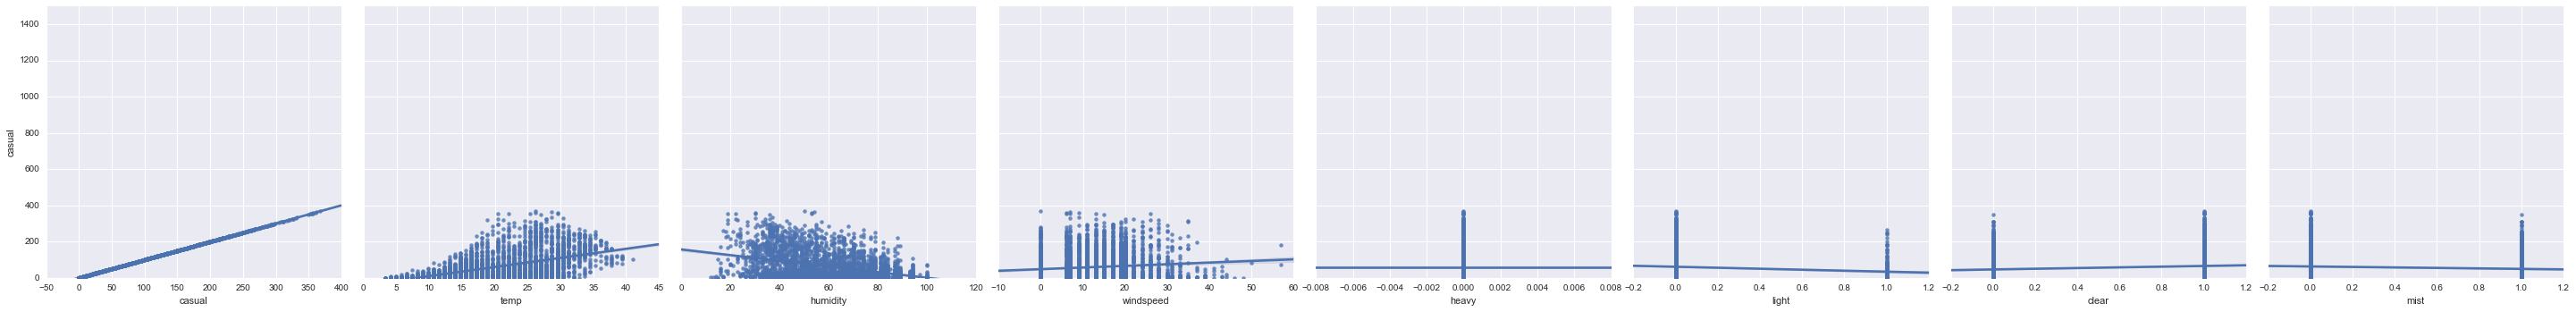

In [10]:
y = 'casual'
pairplot(train[train['workingday'] == 0], [y, 'temp', 'humidity', 'windspeed', 'heavy', 'light', 'clear', 'mist'], y_var=[y])

I could do some crazy multiple regression time series or I could make more dummy variable for time of day.  Time of day is reasonable to include since there are distinctly different commuting behaviors: "going to work", "leaving work" , during the week.  

**Since the weekend is is distinctly different from the workweek I will make a model for each. **



In [159]:
train_wk_day = train[train['workingday'] == 1]
train_wknd = train[train['workingday'] == 0]

##### Week Day

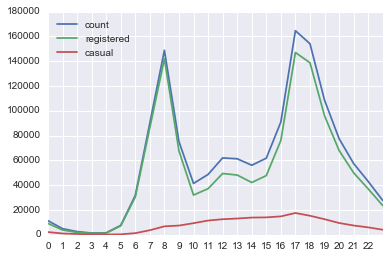

In [160]:
train_hours = train_wk_day.groupby(train_wk_day.index.hour)[['count', 'registered', 'casual']].sum()
train_hours.plot(xticks=range(0,23,1))

##### Weekend

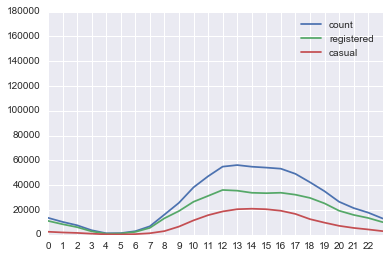

In [161]:
train_wknd_hours = train_wknd.groupby(train_wknd.index.hour)[['count','registered','casual']].sum()
train_wknd_hours.plot(xticks=range(0,23,1), ylim=(0, 180000))

Per our intuition there is a daily pattern.  As you might expect since most don't work on the weekends, casual riders has a much more gradual curve.  

The Registered appear to follow a 5th order (ish).  

In [142]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
est = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
est.fit(X_train,y_train)
est.score(X_test,y_test), est.score(X_train, y_train)

(0.30805235935086051, 0.32215019227527231)

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

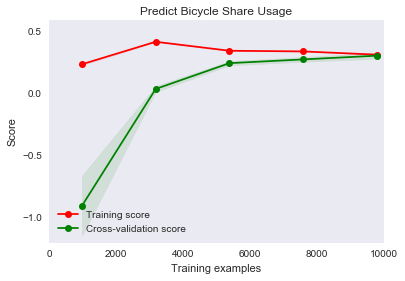

In [132]:
plot_learning_curve(est, 'Predict Bicycle Share Usage', X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

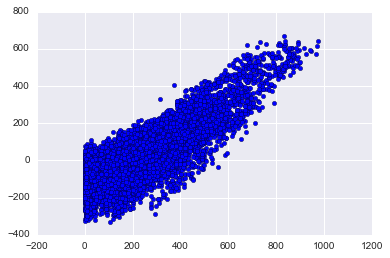

In [144]:
y_pred = est.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)

There is something I'm missing.  I suspect this is becuase I'm not taking into account the high points during the day.  To do this I can make buckets of time.

## Add hour of day as dummy variable.

In [154]:
train = train.join(pd.get_dummies(train.index.hour, prefix='hr').set_index(train.index))
train.index = pd.to_datetime(train.index)
# train = train.join(pd.get_dummies(train.index.dayofweek, prefix='daywk').set_index(train.index))
# train.index = pd.to_datetime(train.index)

### Let's run the models again with hours included

In [156]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
est = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
est.fit(X_train,y_train)
est.score(X_test,y_test), est.score(X_train, y_train)
y_pred = est.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)

(0.82721217089513277, 0.83722211052122908)

Evaluate performance thus far using the `validation curve` from `sklearn.learning_curve`

In [ ]:
estimator = make_pipeline(PolynomialFeatures(2), Ridge())

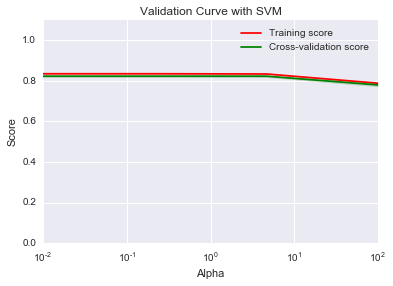

In [138]:

param_range = np.logspace(-2, 2, 4)
train_scores, test_scores = validation_curve(
    estimator, X, y, param_name='ridge__alpha',
    param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

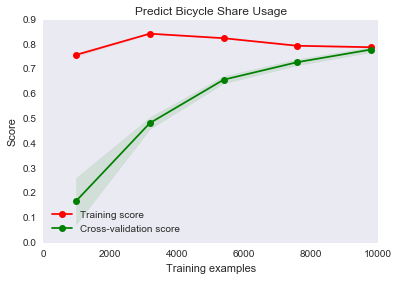

In [139]:
plot_learning_curve(estimator, 'Predict Bicycle Share Usage', X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

## Feature Engineering

What other patterns are in here that we're not seeing

Looking for more signal, there might be different behaviors for different parts of the year.  

Hours and day of week

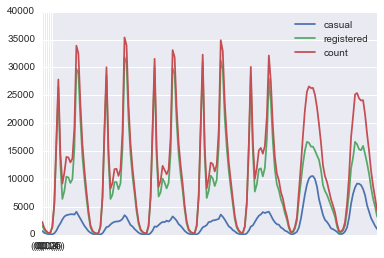

In [182]:
train_day_hr = train.groupby([train.index.dayofweek, train.index.hour]).sum()[['casual', 'registered', 'count']]
train_day_hr.plot(xticks=range(0,6,1))

What about hours and month of year

In [191]:
train_wkday = train[train.index.day]

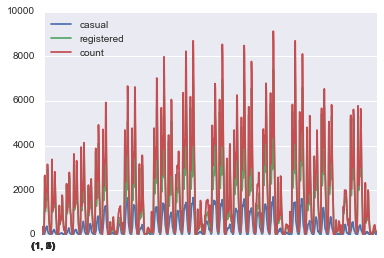

In [199]:
train_day_hr = train.groupby([train.index.weekofyear, train.index.hour]).sum()[['casual', 'registered', 'count']]
train_day_hr.plot(xticks=range(0,6,1))

In [201]:
train = train.join(pd.get_dummies(train.index.weekofyear, prefix='wk').set_index(train.index))
train.index = pd.to_datetime(train.index)

In [203]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

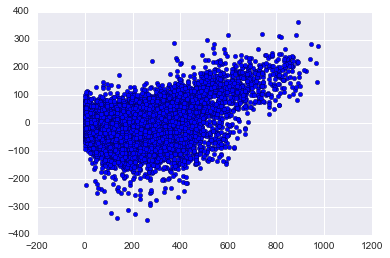

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
est = make_pipeline(PolynomialFeatures(2), RidgeCV(cv=5))
est.fit(X_train,y_train)

y_pred = est.predict(X)
residuals = y - y_pred
plt.scatter(y, residuals)

In [219]:
est.score(X_test,y_test), est.score(X_train, y_train)

(0.84146750249589908, 0.8744379132551563)

In [223]:
estimator = make_pipeline(PolynomialFeatures(2), Ridge(alpha=.1))

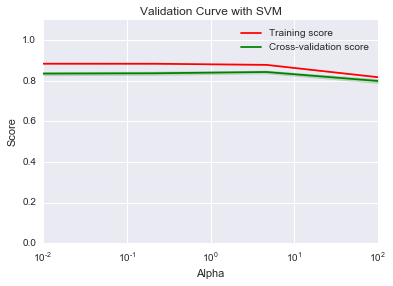

In [207]:
param_range = np.logspace(-2, 2, 4)
train_scores, test_scores = validation_curve(
    estimator, X, y, param_name='ridge__alpha',
    param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

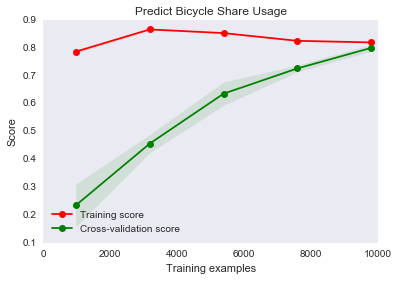

In [208]:
plot_learning_curve(estimator, 'Predict Bicycle Share Usage', X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

In [226]:
cross_val_score(estimator, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True))

array([ 0.84563304,  0.83113207,  0.8486185 ,  0.83813432,  0.82846855,
        0.82493564,  0.8340569 ,  0.84196889,  0.8297706 ,  0.84226067])

In [229]:
results = estimator.fit(X,y)

In [225]:
estimator.score(X,y)

0.88256120793522297

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt